### LSTM tutorial

This is to implement LSTM model based on PyTorch. 

As sometimes we want to process some data with time goes by like `time series` problem, or data with `time relationship`, or we want to overcome with `vanishing / exploding gradient problem`, then we would like to use RNN models, as RNN could remember what information should be considered for later use. 

For example, RNNs are use in `Machine Translation` many times, as we have to remember the whole before information than we could do translation from English to Chinese! So this is just an example with multi-input and multi-output. 

There are many types module based on data: 
    
    1. single-input -> single output; 
    2. multi-input -> single-output; 
    3. single-input -> multi-output; 
    4. multi-input -> multi-output; 
    5. etc. 
    
Here I just make an example data with MNIST to do multi-input as pixels to single output as labels.

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from matplotlib import style

style.use('ggplot')

In [2]:
# if there is a GPU, then we could put data and model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# some hyper-parameters
sequence_size = 28
input_size = 28
n_layers = 2
hidden_size = 128
n_classes = 10
batch_size = 100
epochs = 5
learning_rate = .001


In [4]:
# then we should download data with MNIST
train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                        transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                       transform=transforms.ToTensor(), download=True)
trainloader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data,
                                         batch_size=batch_size,
                                         shuffle=False)

In [5]:
# after we get training and testing data, then we could define our model structure
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        # RNN has two important parts: hidden states and cell states,
        # here should init our hidden states and cell states with 0
        # this means: how many layers * how many samples * how many hidden units
        h0 = torch.zeros(n_layers, x.size()[0], hidden_size).to(device)
        c0 = torch.zeros(n_layers, x.size()[0], hidden_size).to(device)

        x = x.float()     # change to float type
        # we could do forward step with LSTM
        # pass data and init hidden states and cell states
        # we just want to get outputs without hidden outputs with: batch_size * sequence_size * hidden_size
        outs, _ = self.lstm(x, (h0, c0))

        # linear output with only the last cell outputs as prediction!
        outs = self.fc(outs[:, -1, :])
        return outs

In [6]:
# we could init our model, put instanced model to device
model = LSTMNet().to(device)
print("Get model Structure:", model)

Get model Structure: LSTMNet(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
# as we have get our model, then we should define training optimizer and loss evaluation object
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [8]:
# store each epoch training loss and test accuracy
train_loss_list = []
test_acc_list = []

In [9]:
# as we have get whole thing, now start training, oohu :)
for epoch in range(epochs):
    # loop each samples in training data
    curr_loss = []
    for i, (images, labels) in enumerate(trainloader):
        # reshape training data to -1 * 28 * 28
        images = images.reshape(-1, sequence_size, input_size).to(device)
        labels = labels.to(device)

        # get predition
        pred_train = model(images)

        # get loss
        loss_train = criterion(pred_train, labels)

        # backward step and update parameters
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print("{Epoch: %d} Loss: %.2f" % (epoch, loss_train))
        curr_loss.append(loss_train)

    train_loss_list.append(curr_loss)

    # after each epoch, we should evaluate our model with test data
    with torch.no_grad():
        total_size = len(testloader)
        correct_pred = 0
        for images, labels in testloader:
            images = images.reshape(-1, sequence_size, input_size).to(device)
            labels = labels.to(device)

            pred_test = model(images)
            _, preds = torch.max(pred_test, 1)
            total_size += labels.size()[0]
            correct_pred += (preds == labels).sum().item()
        test_acc_list.append((correct_pred / total_size) * 100)

{Epoch: 0} Loss: 2.30
{Epoch: 0} Loss: 0.80
{Epoch: 0} Loss: 0.43
{Epoch: 0} Loss: 0.31
{Epoch: 0} Loss: 0.23
{Epoch: 0} Loss: 0.33
{Epoch: 1} Loss: 0.02
{Epoch: 1} Loss: 0.10
{Epoch: 1} Loss: 0.13
{Epoch: 1} Loss: 0.13
{Epoch: 1} Loss: 0.19
{Epoch: 1} Loss: 0.09
{Epoch: 2} Loss: 0.17
{Epoch: 2} Loss: 0.05
{Epoch: 2} Loss: 0.05
{Epoch: 2} Loss: 0.09
{Epoch: 2} Loss: 0.12
{Epoch: 2} Loss: 0.06
{Epoch: 3} Loss: 0.12
{Epoch: 3} Loss: 0.03
{Epoch: 3} Loss: 0.10
{Epoch: 3} Loss: 0.09
{Epoch: 3} Loss: 0.22
{Epoch: 3} Loss: 0.02
{Epoch: 4} Loss: 0.03
{Epoch: 4} Loss: 0.05
{Epoch: 4} Loss: 0.03
{Epoch: 4} Loss: 0.05
{Epoch: 4} Loss: 0.06
{Epoch: 4} Loss: 0.01


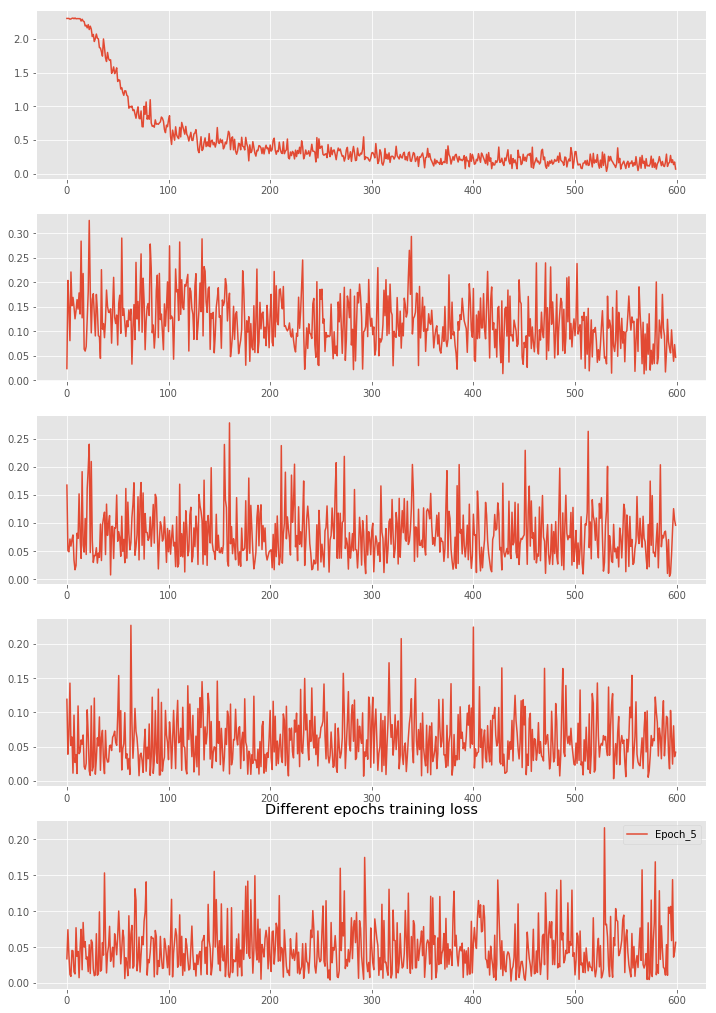

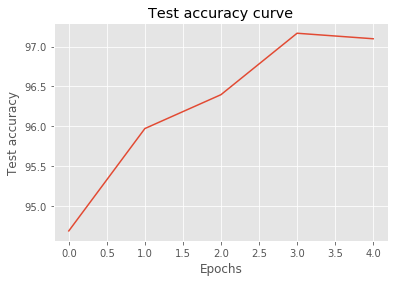

In [10]:
# Here I just wnat to plot 2 graphs, first is each epochs training loss curve
# the other is the test accuracy curve
fig, ax = plt.subplots(len(train_loss_list), 1, figsize=(12, 18))
for i in range(len(train_loss_list)):
    ax[i].plot(range(len(train_loss_list[i])), train_loss_list[i], label='Epoch_' + str(i + 1))
plt.title("Different epochs training loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(len(test_acc_list)), test_acc_list)
plt.title("Test accuracy curve")
plt.xlabel("Epochs")
plt.ylabel("Test accuracy")
plt.grid(True)

plt.show()


In [11]:
# we could save our trained model checkpoint to disk, here I just save
# it to a temperate folder, you could just change the path you want
tmp_path = tempfile.mkdtemp()
torch.save(model.state_dict(), os.path.join(tmp_path, 'model.ckpt'))
print("Get model:", os.listdir(tmp_path))
# remove the temperate folder
shutil.rmtree(tmp_path)

Get model: ['model.ckpt']
